In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid', context='talk', palette='colorblind')

## Keywords

In [2]:
df = pd.read_csv('paperlist.tsv', index_col=0, sep='\t')
print('# papers:', len(df))
df.head()

# papers: 161


,title,link,keywords,abstract
paper_id,,,,
skFwlyefkWJ,MiniHack the Planet: A Sandbox for Open-Ended ...,https://openreview.net/forum?id=skFwlyefkWJ,NaN,The progress in deep reinforcement learning (R...
KBbxt3JGn0Y,One Million Scenes for Autonomous Driving: ONC...,https://openreview.net/forum?id=KBbxt3JGn0Y,"autonomous driving, 3D object detection, datas...",Current perception models in autonomous drivin...
TAdzPkgnnV8,The Tarteel Dataset: Crowd-Sourced and Labeled...,https://openreview.net/forum?id=TAdzPkgnnV8,"natural language processing, speech recognitio...",We propose a standard schema for paired Qurani...
PQldd-oUHa8,“There will be consequences!” Datasets and Ben...,https://openreview.net/forum?id=PQldd-oUHa8,NaN,"In this paper, we discuss the creation of data..."
t1kTABPcp9s,"Indian-CT, Dataset and Analysis of Chest CT Sc...",https://openreview.net/forum?id=t1kTABPcp9s,"COVID-19, Convolutional Neural Networks, Compu...",An Indian dataset of chest Computed Tomography...


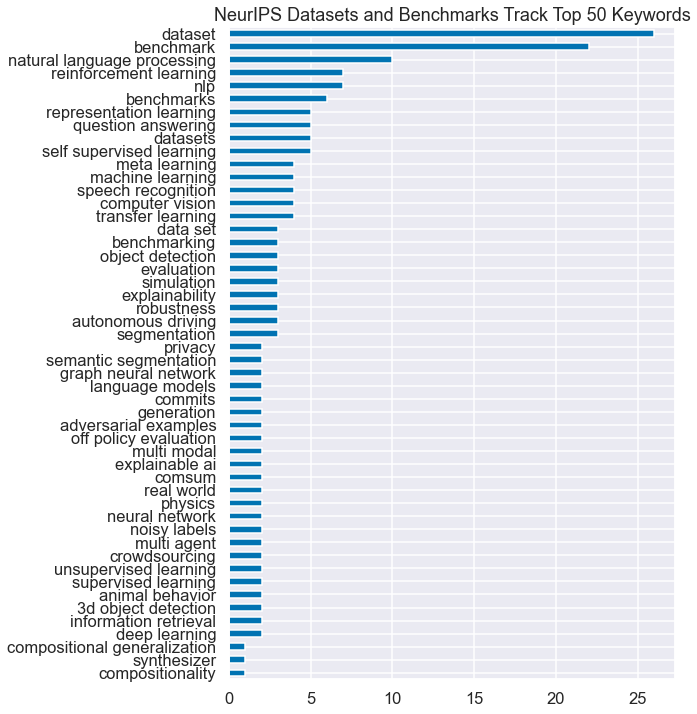

In [3]:
counts = pd.Series(
    ', '.join(df['keywords'].dropna()).lower().replace('-', ' ').replace('networks', 'network').split(',')
).str.strip().value_counts().sort_values(ascending=True)
counts.iloc[-50:].plot.barh(figsize=(8, 12), title='NeurIPS Datasets and Benchmarks Track Top 50 Keywords')
plt.savefig('asset/keywords.png', dpi=300, bbox_inches='tight')

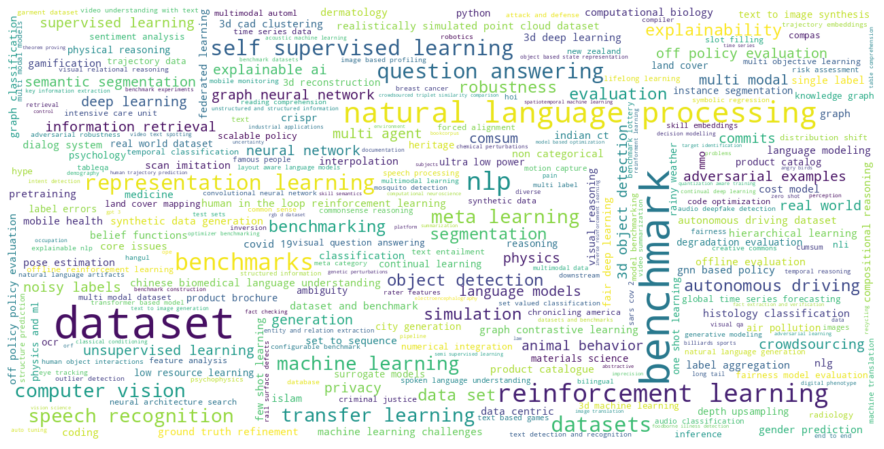

In [4]:
from imageio import imread
from wordcloud import WordCloud

wc = WordCloud(background_color="white", max_words=300, max_font_size=64, 
               width=1280, height=640, random_state=0)
wc.generate_from_frequencies(counts.to_dict())
fig = plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig('asset/wordcloud.png', dpi=300, bbox_inches='tight')

## Rating Distributions

In [5]:
ratings = pd.read_csv('ratings.tsv', sep='\t', index_col=0)
print(ratings.iloc[:, :-1].stack().mean())
ratings.head()

5.7272727272727275


,0,1,2,3,4,decision
paper_id,,,,,,
skFwlyefkWJ,6.0,5.0,7.0,NaN,NaN,Unknown
KBbxt3JGn0Y,6.0,5.0,7.0,NaN,NaN,Unknown
TAdzPkgnnV8,4.0,4.0,6.0,NaN,NaN,Unknown
PQldd-oUHa8,3.0,2.0,4.0,NaN,NaN,Unknown
t1kTABPcp9s,4.0,3.0,1.0,NaN,NaN,Unknown


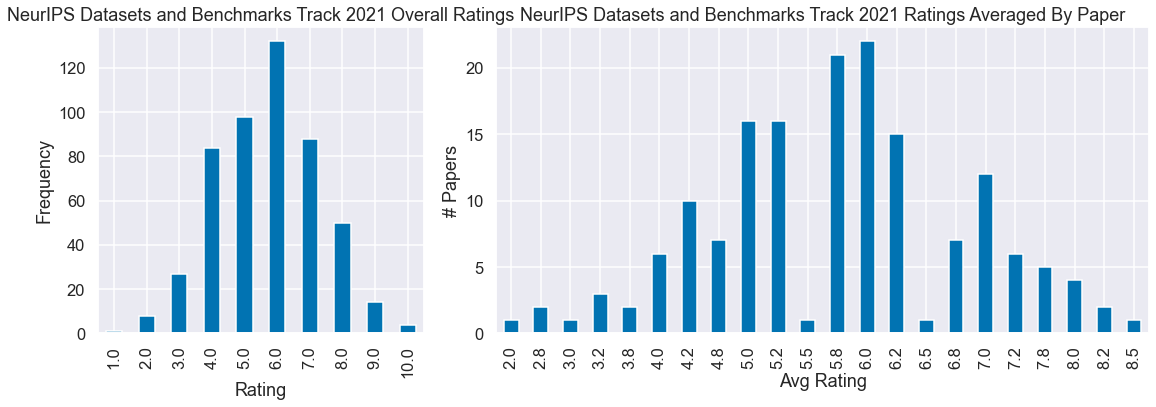

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 2]})
ratings.iloc[:, :-1].stack().value_counts().sort_index().plot.bar(
    ax=axes[0], title='NeurIPS Datasets and Benchmarks Track 2021 Overall Ratings', xlabel='Rating', ylabel='Frequency')
ratings.iloc[:, :-1].mean(axis=1).mul(4).round().div(4).round(1).value_counts().sort_index().plot.bar(
    ax=axes[1], title='NeurIPS Datasets and Benchmarks Track 2021 Ratings Averaged By Paper', xlabel='Avg Rating', ylabel='# Papers')
plt.tight_layout()
plt.savefig('asset/ratings_dist.png', dpi=300, bbox_inches='tight')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


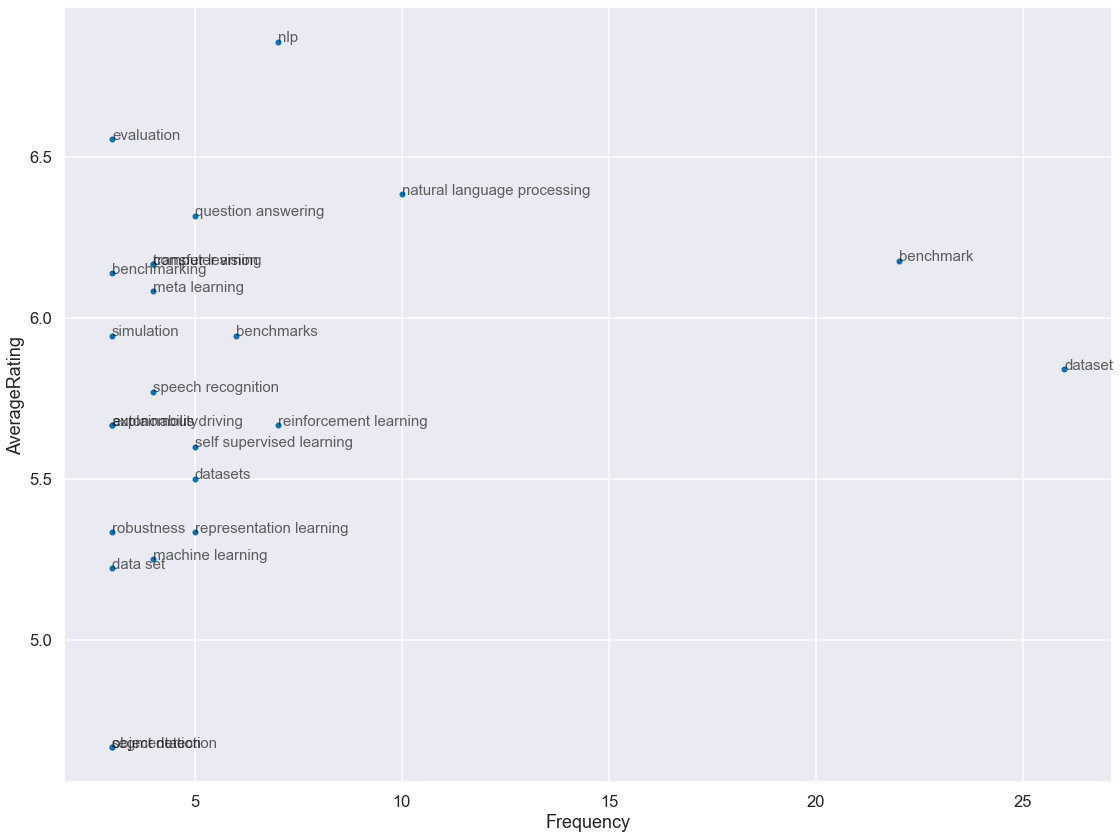

In [7]:
data = {}
for keywords, rating in zip(df.keywords, ratings.iloc[:, :-1].mean(axis=1)):
    if (isinstance(keywords, float) and np.isnan(keywords)) or np.isnan(rating):
        continue
    for keyword in keywords.lower().replace('-', ' ').replace('networks', 'network').split(','):
        data.setdefault(keyword.strip(), []).append(rating)

t = pd.DataFrame({
    'Frequency': [min(len(v), 50) for v in data.values()], # clip to 50
    'AverageRating': [np.mean(v) for v in data.values()],
    'Keyword': list(data.keys())
}).query('Frequency>2')
t.plot.scatter(x='Frequency', y='AverageRating', figsize=(16, 12))

for i in range(len(t)):
     plt.text(t.Frequency.iloc[i], t.AverageRating.iloc[i], t.Keyword.iloc[i], 
              horizontalalignment='left', 
              size='small', color='black', alpha=0.6)

plt.tight_layout()
plt.savefig('asset/keyword_ratings.png', dpi=300, bbox_inches='tight')

## Top 50 Papers

In [8]:
pd.RangeIndex?

In [9]:
comb_df = pd.DataFrame({
    'AvgRating': ratings.iloc[:, :-1].mean(axis=1).round(2),
    'STDRating': ratings.iloc[:, :-1].std(axis=1).round(2),
    'Title': '[' + df['title'] + ']' + '(' + df['link'] + ')',
    'Ratings': ratings.iloc[:, :-1].apply(lambda x: ', '.join(x.dropna().astype(int).astype(str).values), axis=1),
    'Decision': ratings.iloc[:, -1],
})

comb_df = comb_df.sort_values(['AvgRating', 'STDRating'] , ascending=[False, True]).reset_index(drop=True)
comb_df.index += 1
comb_df.index.name = 'Rank'
comb_df.head(50)

,AvgRating,STDRating,Title,Ratings,Decision
Rank,,,,,
1,8.50,1.00,[RadGraph: Extracting Clinical Entities and Re...,"9, 9, 9, 7",Unknown
2,8.33,1.15,[ATOM3D: Tasks on Molecules in Three Dimension...,"9, 9, 7",Unknown
3,8.33,1.53,[Pervasive Label Errors in Test Sets Destabili...,"7, 10, 8",Unknown
4,8.00,0.00,[Programming Puzzles](https://openreview.net/f...,"8, 8, 8",Unknown
5,8.00,1.00,[A Large-Scale Database for Graph Representati...,"7, 8, 9",Unknown
6,8.00,1.00,[CCNLab: A Benchmarking Framework for Computat...,"8, 9, 7",Unknown
7,8.00,1.73,[CommonsenseQA 2.0: Exposing the Limits of AI ...,"7, 7, 10",Unknown
8,7.67,0.58,[Q-Pain: A Question Answering Dataset to Measu...,"8, 7, 8",Unknown
9,7.67,0.58,[Which priors matter? Benchmarking models for ...,"8, 8, 7",Unknown


In [10]:
with open('ranked_papers.md', 'w', encoding='utf8') as f:
    comb_df.to_markdown(f)